# Enhanced model for recommendation system

Outline:
1. Database connection. Data preprocessing. #postgresql
2. Feature extraction from unlabeled text. 

    2.1 Extract and handle BERT embeddings #bert 

    2.2 Clusterize embeddings #pca #kmeans #dec #nlpaugmentation (TODO: #idec)
3. Model training and evaluating #catboost

    3.1 Default catboost

    3.2 TODO: Tuned catboost
4. Model saving and feature uploading to server

Intro:

Recently I found an interesting [paper by Subakti et al. (2022)](https://journalofbigdata.springeropen.com/articles/10.1186/s40537-022-00564-9), which relates to the problem of BERT embeddings clusterization. In paper, there are several proposed strategies: proper BERT embeddings handling (pooling&normalization) combined with different techniques, such as KMeans, DEC (Deep Embedded Clustering), IDEC (Improved DEC), fuzzy C-Means. I tried to play with DEC&IDEC because they had the best performance (see Subakti's paper). Unfortunately, there was no acceptable pytorch implementation, so I rewrote existing solutions and applied rewritten DEC and IDEC for current task. *See [my DEC/IDEC_mnist repo](https://github.com/grokhi/pytorch_DEC_IDEC_2022) for details*

tl;dr:
- Deep Embedded Clustering (DEC) trained on augmented dataset showed 92% cluster accuracy (b/line kmeans 58%). Extracted features were used for catboost training
- Unfortunately, default catboost model (.65) showed less ROC-AUC score than in base model (.67). Need to tune it
- Tuned catboost results: #TODO.

TODO: What's next? Obtained results from base_model and enhanced_model will be validated using scheduling A/B tests on a local server. #abtests #airflow #docker #postgresql *See [file-not-yet-ready] for details*

## 1. Connect to DB

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

CONN = "postgresql://robot-startml-ro:pheiph0hahj1Vaif@"\
    "postgres.lab.karpov.courses:6432/startml"

In [2]:
# User data

user_info = pd.read_sql(
    """SELECT * FROM public.user_data""",
    con=CONN
)

# user_info = pd.read_csv('data/user_info.csv', index_col=0)
print(user_info.shape)
user_info.sample(5)

(163205, 8)


,user_id,gender,age,country,city,exp_group,os,source
12786,12989,0,20,Russia,Novosibirsk,4,iOS,ads
14988,15198,1,20,Russia,Tomsk,3,Android,ads
6799,7002,1,32,Russia,Makhachkala,0,Android,ads
161608,166953,1,50,Russia,Seversk,1,Android,organic
53719,57438,1,26,Russia,Saint Petersburg,1,iOS,ads


In [3]:
# Posts and topics

posts_info = pd.read_sql(
    """SELECT * FROM public.post_text_df""",
    con=CONN
)

# posts_info = pd.read_csv('data/posts_info.csv', index_col=0)

print(posts_info.shape)
posts_info.sample(5)

(7023, 3)


,post_id,text,topic
923,797,George Michael to perform for BBC\n\nGeorge Mi...,entertainment
2373,1947,Camera phones are must-haves\n\nFour times mor...,tech
5610,5840,"I just saw this film on DVD last night, and de...",movie
5612,5842,.... And after seeing this pile of crap you wo...,movie
3592,3749,Today on the #CNBCConversation: Chief Economis...,covid


In [4]:

feed_data = pd.read_sql(
    """SELECT * FROM public.feed_data LIMIT 1000000""",
    con=CONN
)

# feed_data = pd.read_csv('data/feed_data.csv', index_col=0)

# remove likes
feed_data = feed_data[feed_data.action == 'view']

print(feed_data.shape)
feed_data.sample(5)

(894030, 5)


,timestamp,user_id,post_id,action,target
542951,2021-11-29 09:04:29,4634,1252,view,0
303621,2021-11-21 11:04:37,89987,5234,view,0
112333,2021-11-21 16:39:17,38283,2001,view,1
499252,2021-10-31 21:20:46,4602,6042,view,0
919512,2021-10-31 10:38:02,90729,1551,view,1


# 2. Feature preprocessing

## 2.1 posts_info.text feature extraction using BERT

### 2.1a Getting BERT embeddings

In [5]:
# let's map text to embedding
from transformers import AutoTokenizer
# https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertModel
from transformers import BertModel


def get_model(model_name):
    assert model_name in ['bert_cased','bert_uncased',]

    checkpoint_names = {
        'bert_cased': 'bert-base-cased',  # https://huggingface.co/bert-base-cased
        'bert_uncased': 'bert-base-uncased',  # https://huggingface.co/bert-base-uncased
    }

    model_classes = {
        'bert_cased': BertModel,
        'bert_uncased': BertModel,
    }

    return (
        AutoTokenizer.from_pretrained(checkpoint_names[model_name]),
        model_classes[model_name].from_pretrained(checkpoint_names[model_name])
    )


In [6]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding


class PostDataset(Dataset):
    def __init__(self, texts, tokenizer):
        super().__init__()

        self.texts = tokenizer.batch_encode_plus(
            texts,
            add_special_tokens=True,
            return_token_type_ids=False,
            max_length=512,
            return_tensors='pt',
            truncation=True,
            padding=True
        )
        self.tokenizer = tokenizer

    def __getitem__(self, idx):
        return {'input_ids': self.texts['input_ids'][idx], 'attention_mask': self.texts['attention_mask'][idx]}

    def __len__(self):
        return len(self.texts['input_ids'])


def reload(values, tokenizer):
    dataset = PostDataset(values.tolist(), tokenizer)

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    loader = DataLoader(dataset, batch_size=32,
                        collate_fn=data_collator, pin_memory=True, shuffle=False)

    return (
        dataset, data_collator, loader
    )


In [7]:
import torch
from tqdm import tqdm


@torch.inference_mode()
def get_embeddings_labels(model, loader, device):  
    model.eval()
    model.to(device)
 
    total_embeddings = []

    for batch in tqdm(loader):
        batch = {key: batch[key].to(device)
                 for key in ['attention_mask', 'input_ids']}

        embeddings = model(**batch)['last_hidden_state'][:, :25, :] #as in paper Subakti (2022)

        total_embeddings.append(embeddings.cpu())

    return torch.cat(total_embeddings, dim=0)


In [8]:
tokenizer, model = get_model('bert_uncased')

dataset, data_collator, loader = reload(posts_info['text'].values, tokenizer)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)
print(torch.cuda.get_device_name())

model = model.to(device)


cuda:0
NVIDIA GeForce GTX 1060 with Max-Q Design


In [10]:
embeddings = get_embeddings_labels(model, loader, device)

embeddings.shape

100%|██████████| 220/220 [09:12<00:00,  2.51s/it]


torch.Size([7023, 25, 768])

### 2.1b Feature extraction

According to Subakti (2022), different strategies of pooling and normalization may be appliable to the BERT outputs.

Pooling:

In [11]:
def pool_by_tokens(tensor:torch.Tensor, method:str):
    assert method in ['max_pooling', 'mean_pooling']
    _dict = {
        'max_pooling' : lambda tensor: torch.max(tensor, dim=1)[0],
        'mean_pooling' : lambda tensor: torch.mean(tensor, dim=1)
    }
    return _dict[method](tensor).numpy()
    

Normalization:

In [12]:
def normalization(array, method):
    assert method in ['identity', 'standard', 'layer', 'minmax']
    axis = 0
    _dict = {
        'identity' : lambda x: x,
        'standard' : lambda x: x / np.linalg.norm(x, axis=0),
        'layer' : lambda x: (x - x.mean(axis)) / x.std(axis),
        'minmax' : lambda x: (x - x.min(axis)) / (x.max(axis) - x.min(axis))
    }
    return _dict[method](array)

In [14]:
# Getting dictionary with different combinations of extracted embeddings
embdict = {}
for pooling in ['max_pooling', 'mean_pooling']:
    array = pool_by_tokens(embeddings, pooling)
    for norm_method in ['identity', 'standard', 'layer', 'minmax' ]:
        embdict[pooling+'__'+norm_method] = normalization(array, norm_method)

# np.save('bert_embeddings/embdict.npy', embdict)
embdict.keys()        

dict_keys(['max_pooling__identity', 'max_pooling__standard', 'max_pooling__layer', 'max_pooling__minmax', 'mean_pooling__identity', 'mean_pooling__standard', 'mean_pooling__layer', 'mean_pooling__minmax'])

In [15]:
# save text and mapped numeric labels
map_dict = {topic: i for i, topic in enumerate(pd.Series(posts_info.topic.values).value_counts().index.sort_values())}
emb_num_labels = np.vectorize(map_dict.get)(posts_info.topic.values)

# np.save('bert_embeddings/emb_txt_labels.npy', posts_info.topic.values)
# np.save('bert_embeddings/emb_num_labels.npy', emb_num_labels)

According to my tests (*see DEC_BERT_embeddings.ipynb*), only 'layer normalization' (a.k.a. StandardScaler()) allows for smooth learning curve with the best behavior (high metrics + stable learning&performance curves)

In [15]:
embdict = np.load('bert_embeddings/embdict.npy', allow_pickle=True).item()

# we derived that version as the best 
embeddings = embdict['mean_pooling__layer'] 

# possible alternative to 'mean_pooling__layer'
# embeddings = embdict['max_pooling__layer'] 

embeddings.shape

(7023, 768)

## 2.2 Applying different clusterization tecchniques (PCA, KMeans, DEC, DEC-aug)

In [16]:
# evaluate cluster accuracy using hungarian algorithm (finds most accurate combination b2n true and predicted labels)
def cluster_acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed

    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`

    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    from scipy.optimize import linear_sum_assignment 
    row_ind, col_ind = linear_sum_assignment(w.max() - w)
    return w[row_ind,col_ind].sum() / y_pred.size



In [17]:
# funcs for vizualization
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler

def umap_reduce(arr):
    reducer = umap.UMAP()

    scaled = StandardScaler().fit_transform(arr)

    _umap = reducer.fit_transform(scaled)

    return pd.DataFrame({'x': _umap[:, 0], 'y': _umap[:, 1]})

def plot_labels(umap_df, label:str):
    cmap = plt.cm.Set1
    norm = plt.Normalize(umap_df['label'].values.min(),
                        umap_df['label'].values.max())

    size = 10

    for i, dff in umap_df.groupby("label"):
        plt.scatter(dff['x'], dff['y'], s=size, c=cmap(norm(dff['label'])),
                    edgecolors='none', label=label+" {:g}".format(i))

umap_df = umap_reduce(embeddings)

### 2.2a Removing noise from BERT embeddings using PCA decomposition

Rule of thumb: taking *n_components* that capture 90% of variance to reduce noise

In [18]:
from sklearn.decomposition import PCA
pca = PCA(n_components=.9, svd_solver='full') 
# +3%

centered = embeddings - embeddings.mean()
pca_decomp = pca.fit_transform(centered)

print('n_components =', pca_decomp.shape[1])

n_components = 257


### 2.2b Use KMeans clustering and visualize it (both w/ PCA) using UMAP projection

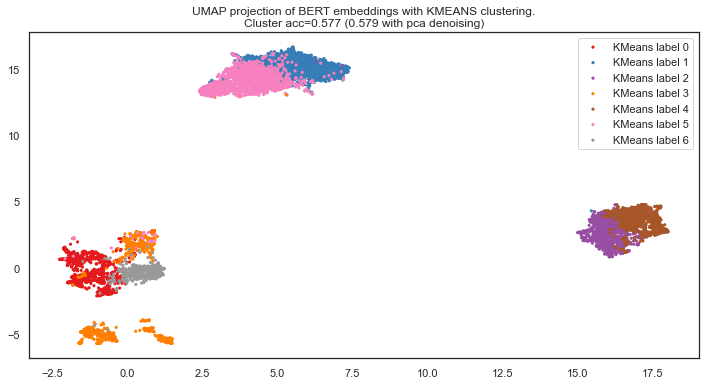

In [20]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=7, random_state=0, n_init=20).fit(embeddings)
posts_info['KMeansTextCluster'] = kmeans.labels_
umap_df['label'] = kmeans.labels_ 
cl_acc = round(cluster_acc(emb_num_labels, kmeans.labels_), 3)

kmeans_pca = KMeans(n_clusters=7, random_state=0, n_init=20).fit(pca_decomp)
umap_df['label'] = kmeans_pca.labels_ 
cl_acc_pca = round(cluster_acc(emb_num_labels, kmeans_pca.labels_), 3)

sns.set(style='white', context='notebook', rc={'figure.figsize': (12, 6)})
plt.title(f'UMAP projection of BERT embeddings with KMEANS clustering.\nCluster acc={cl_acc} ({cl_acc_pca} with pca denoising)')

plot_labels(umap_df, label='KMeans label')
plt.legend()
plt.show()

PCA denoising not making a big deal.

### 2.2c DEC (Deep Embedded Clustering) predictions (trained on original dataset n=7K)

In simple words, DEC is a trained fully-connected encoder with additional learning of KMeans centroids on kullback–leibler (KL) divergence. (see my github for mnist example). In theory (see my github mnist example), additional tuning of trained distribution should give 5-10% performance increase. In practice (see DEC_BERT_embeddngs.ipynb), almost all increase in performance caused by trained encoder - it's very complicate to make KL loss work (some requirements on the dataset must be fullfilled)

dec.png

In [21]:
dec_preds = np.load('dec\predictions\dec_preds.npy')

dec_preds

array([5, 2, 5, ..., 0, 0, 3], dtype=int64)

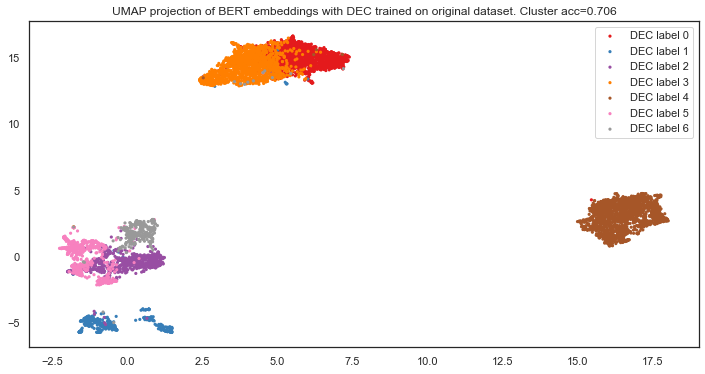

In [22]:
posts_info['DECTextCluster'] = dec_preds
umap_df['label'] = dec_preds

cl_acc = round(cluster_acc(emb_num_labels, dec_preds), 3)

sns.set(style='white', context='notebook', rc={'figure.figsize': (12, 6)})
plt.title(f'UMAP projection of BERT embeddings with DEC trained on original dataset. Cluster acc={cl_acc}')

plot_labels(umap_df, label='DEC label')
plt.legend()
plt.show()

### 2.2d DEC-aug predictions (trained on augmented dataset n=70K)

We managed to get +10-15% performance (comparing to baseline KMeans) only by using autoencoders for the purposes of clusterization (DEC). Let's make another step and try to learn DEC on the augmented dataset. For this purpose, let's use back translation technique for every text item (using pretrained [BERT-multilingual-uncased](https://huggingface.co/bert-base-multilingual-uncased)) and increase the dataset size by 10 times. *See DatasetAugmentation.ipynb and Train_BERTembedaug.ipynb for details*

In [23]:
decaug_preds = np.load('augmented_dataset_results\dec_preds_aug.npy')

decaug_preds

array([2, 3, 2, ..., 6, 6, 6], dtype=int64)

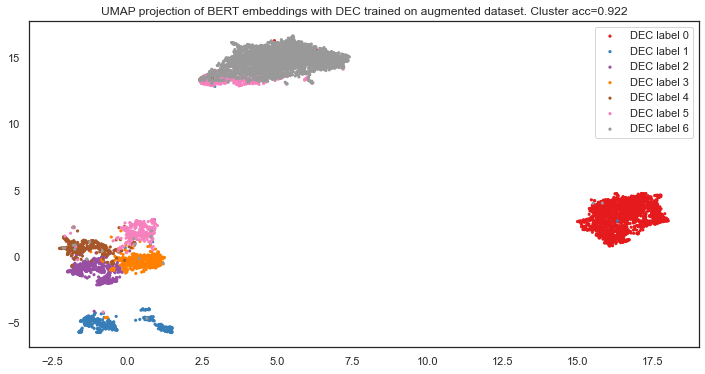

In [24]:
posts_info['DECaugTextCluster'] = decaug_preds
umap_df['label'] = decaug_preds

cl_acc = round(cluster_acc(emb_num_labels, decaug_preds), 3)

sns.set(style='white', context='notebook', rc={'figure.figsize': (12, 6)})
plt.title(f'UMAP projection of BERT embeddings with DEC trained on augmented dataset. Cluster acc={cl_acc}')

plot_labels(umap_df, label='DEC label')
plt.legend()
plt.show()

Amazing! We managed to get +40% (!) increase in cluster accuracy only by training DEC on augmented dataset

## 2.3 Merging features for enchanced model

In [28]:
def get_features(method):
    features = {
        # 'kmeans': kmeans.transform,
        'dec' : np.load(r'dec\predictions\dec_features.npy'),
        'dec_aug' : np.load(r'augmented_dataset_results\dec_features_aug.npy')
    }

    # data = methods[method](df) if method!=None else df

    data = features[method]

    if method=='dec' or method=='dec_aug':
        columns = [f'DECFeature{i}' for i in range(data.shape[1])]
    else:
        columns = [f"DistanceTo{i}thCluster" for i in range(0, data.shape[1])]

    return pd.DataFrame(
        data=data,
        columns=columns
    )

text_features = get_features('dec_aug')
text_features.sample(5)

,DECFeature0,DECFeature1,DECFeature2,DECFeature3,DECFeature4
153,2.240536,-6.907269,-3.422728,2.589213,3.817302
671,2.666051,0.876173,-1.802511,-1.260176,2.157317
5848,0.002745,0.047460,-0.262179,-0.068930,0.001983
5006,2.263693,-0.555451,-2.561119,-0.265974,0.938393
3858,-2.642006,0.687508,-0.886338,2.374358,0.818319


In [30]:
def merge_tables(feat_df):
    _posts_info = posts_info.join(feat_df)

    df = pd.merge(
        feed_data, _posts_info,
        on='post_id', 
        how='left'
    )

    df = pd.merge(
        df, user_info,
        on='user_id',
        how='left')

    ### Extract addtional features from timestamp

    df['hour'] = pd.to_datetime(df['timestamp']).apply(lambda x: x.hour)
    df['month'] = pd.to_datetime(df['timestamp']).apply(lambda x: x.month)

    ### remove unnescessary columns
    df = df.drop([
    #    'timestamp', 
        'action',
        'text',
        'topic', # because we do unsupervised learning
        'KMeansTextCluster', 'DECTextCluster',
       'DECaugTextCluster',
    ],  
        axis=1)

    return df.set_index(['user_id', 'post_id'])

processed_df = merge_tables(text_features)
print(processed_df.shape)
processed_df.columns

(894723, 16)


Index(['timestamp', 'target', 'DECFeature0', 'DECFeature1', 'DECFeature2',
       'DECFeature3', 'DECFeature4', 'gender', 'age', 'country', 'city',
       'exp_group', 'os', 'source', 'hour', 'month'],
      dtype='object')

# 3. Model Training

## 3.1 Default catboost

In [31]:
max(processed_df.timestamp), min(processed_df.timestamp)

('2021-12-29 23:43:15', '2021-10-01 06:01:40')

In [32]:
def prepare_data(df):
    ### Split by 2021-12-15

    df_train = df[df.timestamp < '2021-12-15']
    df_test = df[df.timestamp >= '2021-12-15']

    df_train = df_train.drop('timestamp', axis=1)
    df_test = df_test.drop('timestamp', axis=1)

    X_train = df_train.drop('target', axis=1)
    X_test = df_test.drop('target', axis=1)

    y_train = df_train['target']
    y_test = df_test['target']

    return X_train, y_train, X_test, y_test

In [33]:
### Default Catboost 
from catboost import CatBoostClassifier

catboost_dec_aug = CatBoostClassifier(task_type='GPU')

object_cols = [
    'gender', 'country',
    'city', 'exp_group', 'hour', 'month',
    'os', 'source'
]

X_train, y_train, X_test, y_test = prepare_data(processed_df)

catboost_dec_aug.fit(X_train, y_train, object_cols, verbose=1)

Learning rate set to 0.023431
0:	learn: 0.6741397	total: 149ms	remaining: 2m 28s
1:	learn: 0.6560713	total: 252ms	remaining: 2m 5s
2:	learn: 0.6395985	total: 325ms	remaining: 1m 47s
3:	learn: 0.6234580	total: 430ms	remaining: 1m 47s
4:	learn: 0.6080639	total: 540ms	remaining: 1m 47s
5:	learn: 0.5935338	total: 650ms	remaining: 1m 47s
6:	learn: 0.5801280	total: 760ms	remaining: 1m 47s
7:	learn: 0.5673547	total: 869ms	remaining: 1m 47s
8:	learn: 0.5553847	total: 978ms	remaining: 1m 47s
9:	learn: 0.5435861	total: 1.08s	remaining: 1m 46s
10:	learn: 0.5323848	total: 1.18s	remaining: 1m 46s
11:	learn: 0.5227405	total: 1.22s	remaining: 1m 40s
12:	learn: 0.5130948	total: 1.33s	remaining: 1m 41s
13:	learn: 0.5038562	total: 1.44s	remaining: 1m 41s
14:	learn: 0.4949406	total: 1.54s	remaining: 1m 40s
15:	learn: 0.4869148	total: 1.65s	remaining: 1m 41s
16:	learn: 0.4794542	total: 1.76s	remaining: 1m 41s
17:	learn: 0.4722710	total: 1.86s	remaining: 1m 41s
18:	learn: 0.4655006	total: 1.97s	remaining: 

In [35]:
from sklearn.metrics import roc_auc_score

print(
    f"ROCAUC TRAIN: {roc_auc_score(y_train, catboost_dec_aug.predict_proba(X_train)[:, 1])}")
print(
    f"ROCAUC TEST: {roc_auc_score(y_test, catboost_dec_aug.predict_proba(X_test)[:, 1])}")


ROCAUC TRAIN: 0.6908310111851848
ROCAUC TEST: 0.6537228892841669


Unfortunately, there is no increase in the final metrics even with our great text clusterization. Actually, simple PCA decomposition showed much better results than our sophisticated approach. KISS, huh? :-)

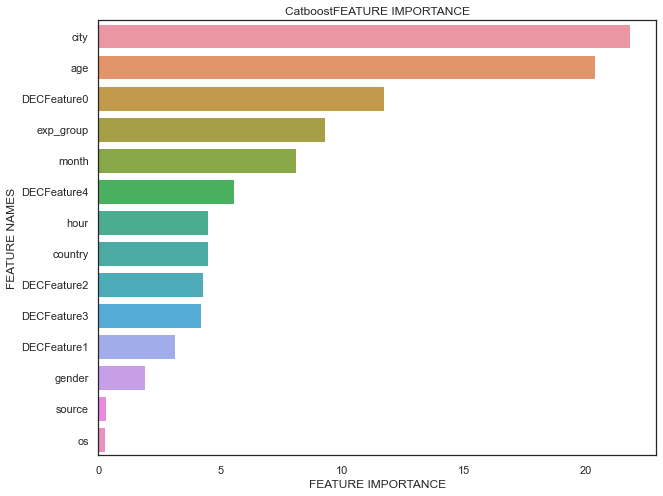

In [37]:
# feature_importance
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


def plot_feature_importance(importance, names, model_type):

    # Create arrays from feature importance and feature names
    feature_importance = np.array(importance)[:20]
    feature_names = np.array(names)[:20]

    # Create a DataFrame using a Dictionary
    data = {'feature_names': feature_names,
            'feature_importance': feature_importance}
    fi_df = pd.DataFrame(data)

    # Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

    # Define size of bar plot
    plt.figure(figsize=(10, 8))
    # Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    # Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')


plot_feature_importance(catboost_dec_aug.feature_importances_,
                        X_train.columns, 'Catboost')


But we didn't tune our catboost yet! Maybe here is a key to a greater model performance?

## 3.2 Tuned catboost

#TODO

# 4. Upload new fetures to the database

In [38]:
posts_info.to_sql(
   "grokhi_enhanced_model_posts_info_features",
    con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml",
    schema="public",
    if_exists='replace'
   )


23

In [39]:
# test upload

test_ = pd.read_sql(
    """SELECT * FROM public.grokhi_enhanced_model_posts_info_features""",

    con="postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml"
)

test_


,index,post_id,text,topic,KMeansTextCluster,DECTextCluster,DECaugTextCluster
0,0,1,UK economy facing major risks\n\nThe UK manufa...,business,3,5,2
1,1,2,Aids and climate top Davos agenda\n\nClimate c...,business,2,2,3
2,2,3,Asian quake hits European shares\n\nShares in ...,business,3,5,2
3,3,4,India power shares jump on debut\n\nShares in ...,business,3,5,2
4,4,5,Lacroix label bought by US firm\n\nLuxury good...,business,3,5,2
...,...,...,...,...,...,...,...
7018,7015,7312,"Mario Lanza, of course, is The Great Caruso in...",movie,4,3,5
7019,7016,7313,"Oh God,what an idiotic movie!Incredibly cheap ...",movie,4,3,6
7020,7017,7314,Although the likeliness of someone focusing on...,movie,1,0,6
7021,7018,7315,"OK, I would not normally watch a Farrelly brot...",movie,1,0,6
